In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/train_split_28.json', 'r') as f:
    train_data = json.load(f)
train_data = [topic for topic in train_data["data"]]
len(train_data)

141402

In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/final (1).json', 'r') as f:
    train_data1 = json.load(f)
train_data1 = [topic for topic in train_data1]

In [ ]:
train_data2 = train_data + train_data1
train_data = train_data2

In [ ]:
val_data = train_data[140000:]
train_data = train_data[:140000]

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.9 MB/s eta 0:00:00


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def func(srt, end, type):
    lst = []
    for i in range(srt, end):
        lst.append(train_data[i][type])
    return lst

In [ ]:
inputs = tokenizer(
    func(2, 6, "Question"),
    func(2, 6, "Paragraph"),
    max_length=204,
    truncation="only_second",
    stride=64,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 4 features.
Here is where each comes from: [0, 1, 2, 3].


In [ ]:
def purify_ans(lst, x):
    for i in range(0, len(lst)):
        lst[i] = lst[i][x:len(lst[i])-x]
    return lst

In [ ]:
def create_dict(val1, val2):
    lst = []
    for i in range(len(val1)):
        dct = {}
        temp = [val1[i]]
        dct["text"] = temp
        if len(val2[i])==0:
            temp=[-1]
        else:    
            temp = [int(val2[i])]
        dct["answer_start"] = temp
        lst.append(dct)
    return lst

In [ ]:
answer_text = purify_ans(func(2, 6 ,"Answer_text"), 2)
answer_start = purify_ans(func(2, 6, "Answer_start"), 1)
answers = create_dict(answer_text, answer_start)
# print(answers)
start_positions = []
end_positions = []
# print(answers)

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([45, 0, 11, 0], [48, 0, 13, 0])

In [ ]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: Dangerously in Love, labels give: Dangerously in Love


In [ ]:
max_length = 204
stride = 64

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["Question"]]
    inputs = tokenizer(
        questions,
        examples["Paragraph"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    # answers_temp = examples["Answer_text"]

    answer_text = purify_ans(examples["Answer_text"], 2)
    answer_start = purify_ans(examples["Answer_start"], 1)
    answers = create_dict(answer_text, answer_start)

    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset

df = pd.DataFrame(train_data)
dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())

### convert to Huggingface dataset
train_data = Dataset(pa.Table.from_pandas(df))
train_data

Dataset({
    features: ['', 'Unnamed: 0', 'Theme', 'Paragraph', 'Question', 'Answer_possible', 'Answer_text', 'Answer_start'],
    num_rows: 140000
})

In [ ]:
train_dataset = train_data.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=train_data.column_names,
)
len(train_data), len(train_dataset)

  0%|          | 0/140 [00:00<?, ?ba/s]

(140000, 142877)

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["Question"]]
    inputs = tokenizer(
        questions,
        examples["Paragraph"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples[""][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
df = pd.DataFrame(val_data)
dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())

val_data = Dataset(pa.Table.from_pandas(df))
val_data

Dataset({
    features: ['', 'Unnamed: 0', 'Theme', 'Paragraph', 'Question', 'Answer_possible', 'Answer_text', 'Answer_start'],
    num_rows: 58961
})

In [ ]:
validation_dataset = val_data.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)
len(val_data), len(validation_dataset)

  0%|          | 0/59 [00:00<?, ?ba/s]

(58961, 65653)

In [ ]:
df = pd.DataFrame(val_data.select(range(100)))
dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
small_eval_set = Dataset(pa.Table.from_pandas(df))
trained_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_data.column_names,
)
eval_set

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 100
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint, num_attention_heads = 8).to(device)

with torch.no_grad():
    outputs = trained_model(**batch)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

In [ ]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

In [ ]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example[""]
    context = example["Paragraph"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )
    # print(answers)
    # break
    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

In [ ]:
import evaluate

metric = evaluate.load("squad")

In [ ]:
theoretical_answers = []
for ex in small_eval_set:
    answer_text = ex["Answer_text"][2:len(ex["Answer_text"])-2]
    answer_start = ex["Answer_start"][1:len(ex["Answer_start"])-1]
    # print(type(answer_start))
    if(answer_start==""):
        answer_start="-1"
    answers = {"text" : [answer_text], "answer_start": [int(answer_start)]}
    theoretical_answers.append({"id": ex[""], "answers": answers}) 

In [ ]:
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '140000', 'prediction_text': 'supply. The supplementary meat and materials from hunting included protein, bone for implements, sinew for cordage, fur, feathers, raw'}
{'id': '140000', 'answers': {'text': ['clothing'], 'answer_start': [323]}}


In [ ]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example[""]
        context = example["Paragraph"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

        theoretical_answers=[]
        for ex in examples:
            answer_text = ex["Answer_text"][2:len(ex["Answer_text"])-2]
            answer_start = ex["Answer_start"][1:len(ex["Answer_start"])-1]
            answers = {"text" : [answer_text], "answer_start": [int(answer_start)]}
            theoretical_answers.append({"id": ex[""], "answers": answers}) 
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint, num_attention_heads = 8)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [ ]:
from huggingface_hub import notebook_login

from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-19,
    num_train_epochs=0.10,
    weight_decay=2e-5,
    fp16=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

In [ ]:
torch.save(model, "/content/drive/MyDrive/Colab Notebooks/modelx5.pt")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = torch.load("/content/drive/MyDrive/Colab Notebooks/modelx5.pt", map_location=torch.device("cuda"))

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

In [ ]:
question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

In [ ]:
%%time
output = question_answerer("Who designed Kubernetes?", "Google originally designed Kubernetes, but the Cloud Native Computing Foundation now maintains the project.")
print(output['answer'], output['score'])

Google 0.9575711488723755
CPU times: user 373 ms, sys: 1.94 ms, total: 375 ms
Wall time: 68.1 ms


In [ ]:
%%time
output = question_answerer("Who won 2022 Football world cup?", "The 2022 FIFA World Cup was an international football tournament contested by the men's national teams of FIFA's member associations and 22nd edition of the FIFA World Cup. It took place in Qatar from 20 November to 18 December 2022.")
print(output['answer'], output['score'])

It took place in Qatar from 20 November to 18 December 2022. 2.976266455512189e-11
CPU times: user 373 ms, sys: 963 µs, total: 374 ms
Wall time: 65.1 ms


In [ ]:
%%time
output = question_answerer("Where did the 2022 football world cup take place?", "It took place in Qatar from 20 November to 18 December 2022.")
print(output['answer'], output['score'])

Qatar 0.9919400811195374
CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 57.4 ms


In [ ]:
%%time
output = question_answerer("Sourav Saini is the co-head of which department?", "Sourav Saini is B.Tech student from IIT Jammu. He is the co-head of AI/ML department.")
print(output['answer'], output['score'])

AI/ML 0.9995474219322205
CPU times: user 416 ms, sys: 0 ns, total: 416 ms
Wall time: 72 ms


In [ ]:
bound = []
for i in range(0, 140000):
    if train_data[i]["Answer_possible"] == "False":
        output= question_answerer(train_data[i]["Question"], train_data[i]["Paragraph"])
        # print(output['score'])
        bound.append(output['score'])
    if i%1000==0:
        print(i)

0


/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

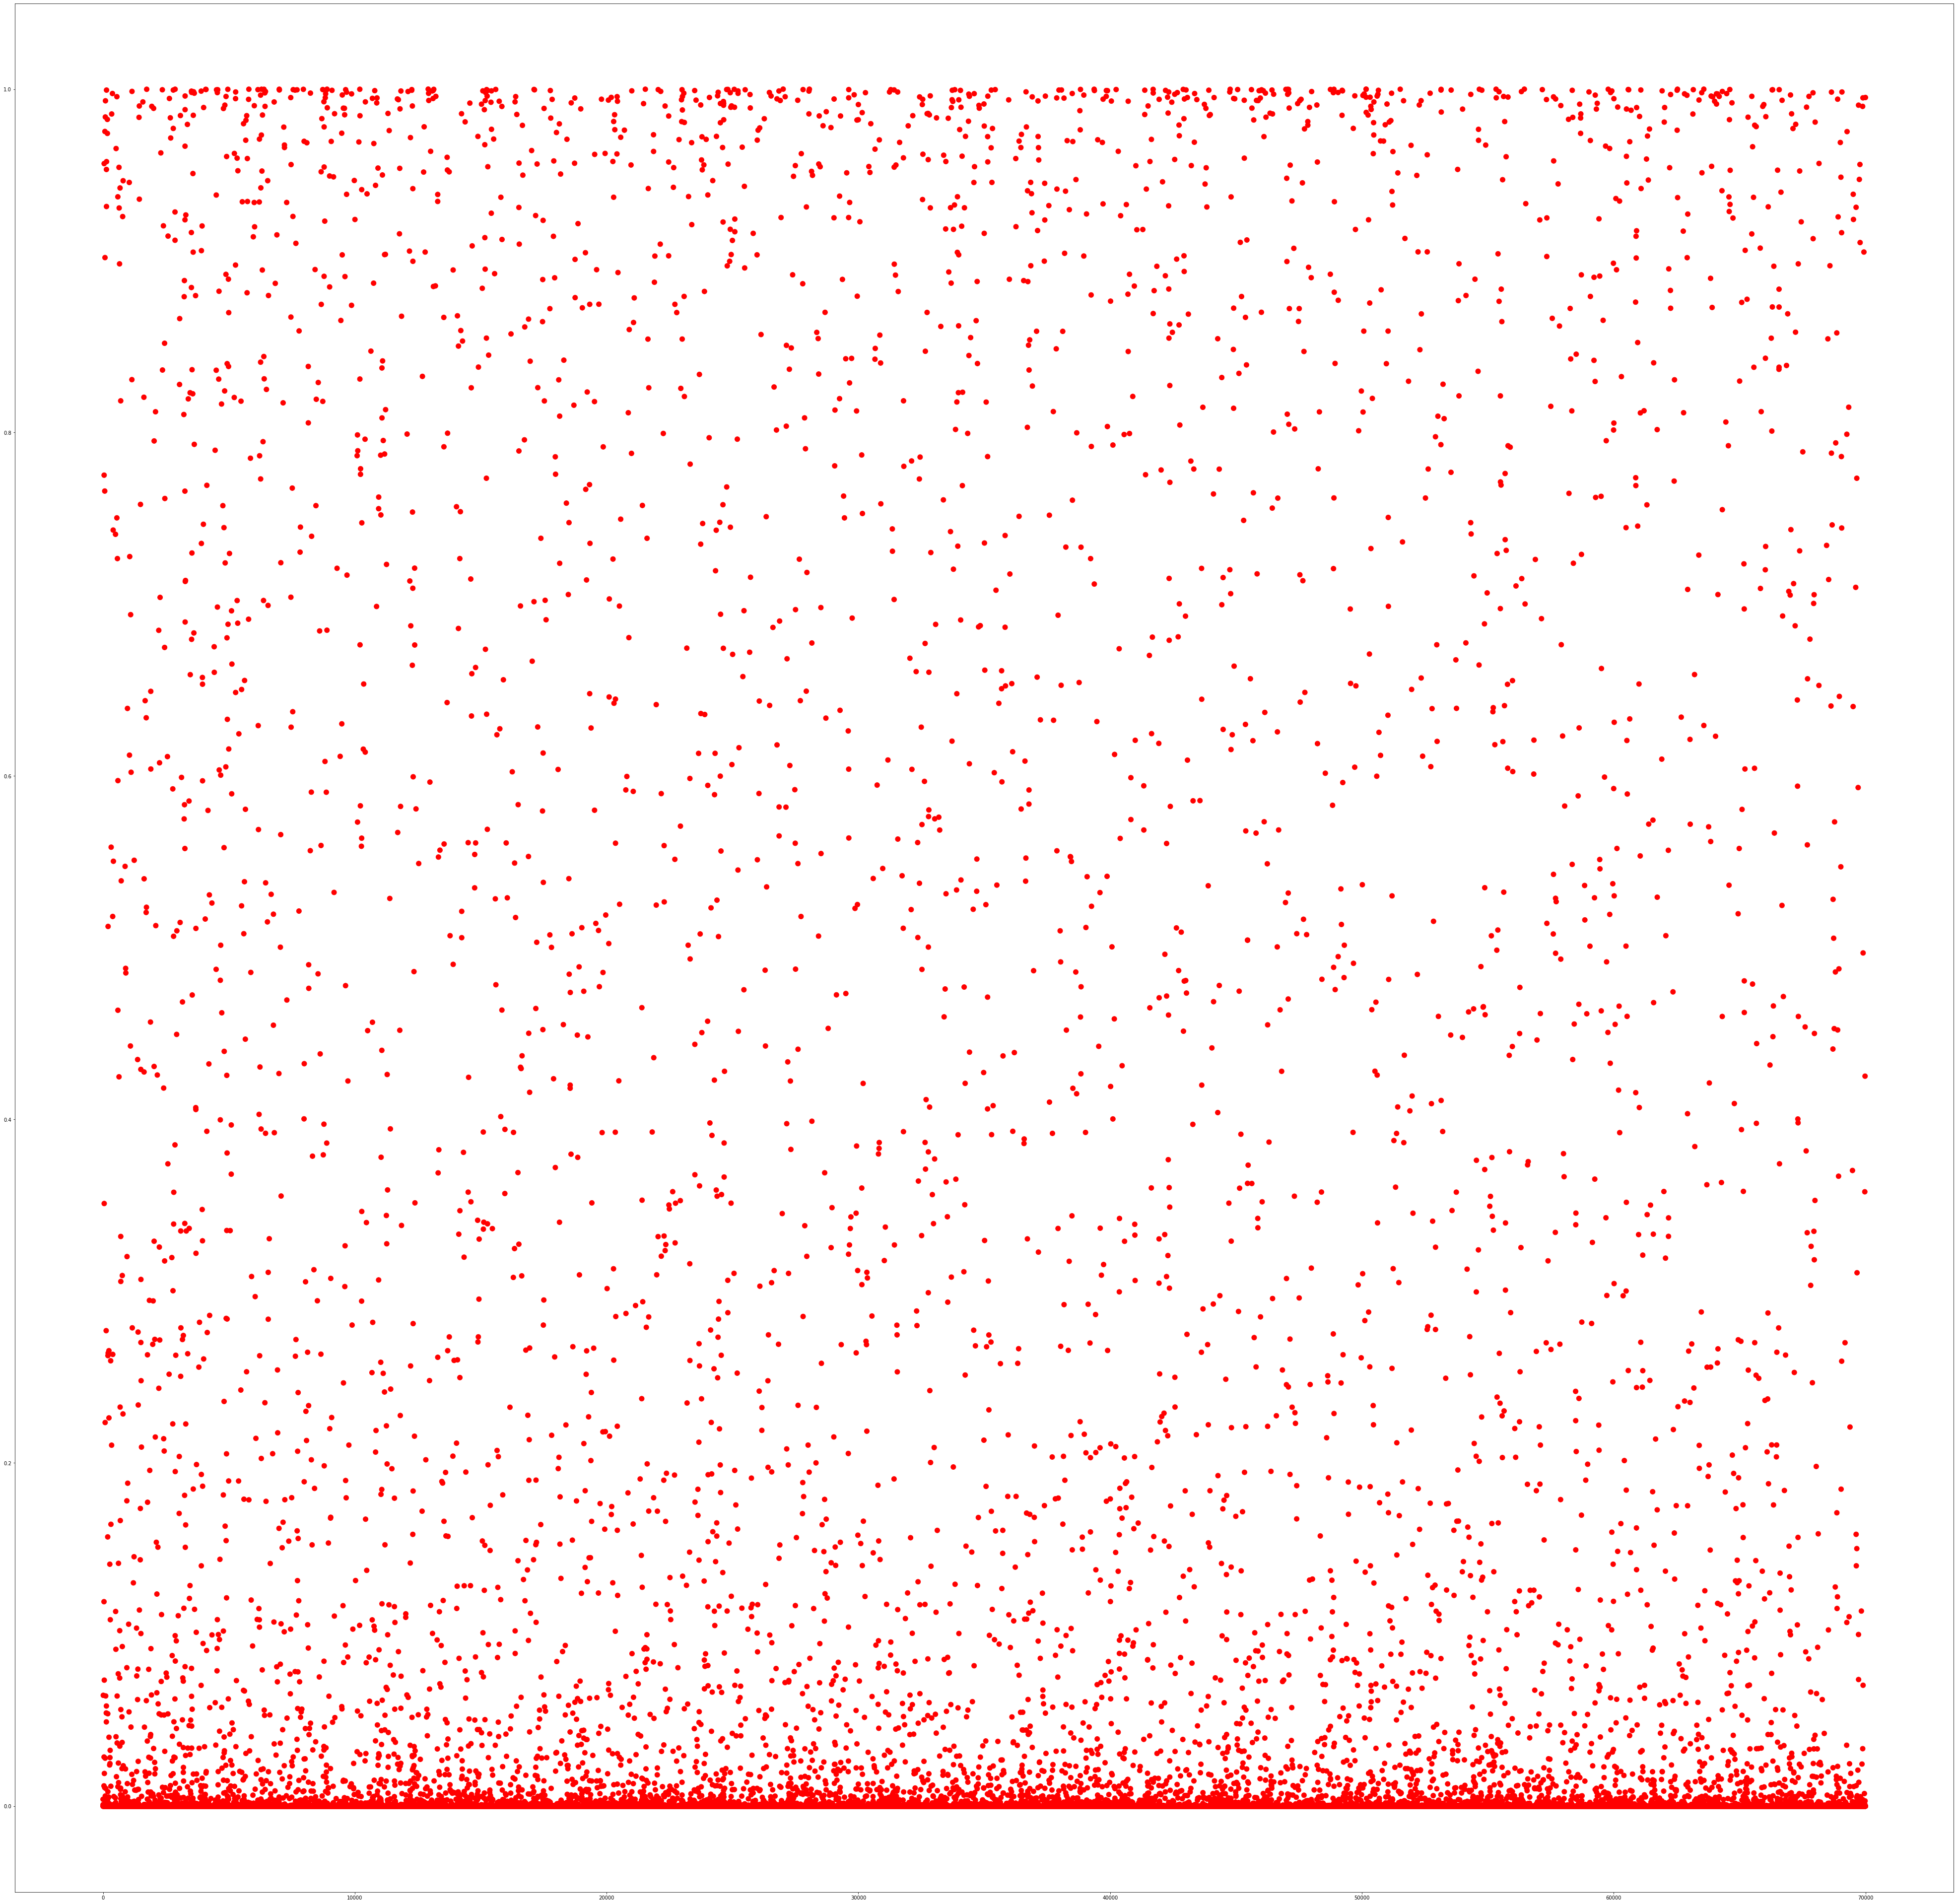

In [ ]:
l = list(range(1, len(bound)+1))
# l_ = list(range(1, len(bound_)+1))
f = plt.figure()
f.set_figwidth(70)
f.set_figheight(70)
# plt.scatter(l_, bound_, color="blue", s=1-np.asarray(bound_))
plt.scatter(l, bound, color="red", s=np.asarray(bound)+100)
plt.show()